In [21]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.50, 0.51), std=(0.35, 0.34), cvar(0.10)=(0.02, 0.02) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.10)=(0.47, 0.47) (computed from 10000.0 saved samples)
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999999


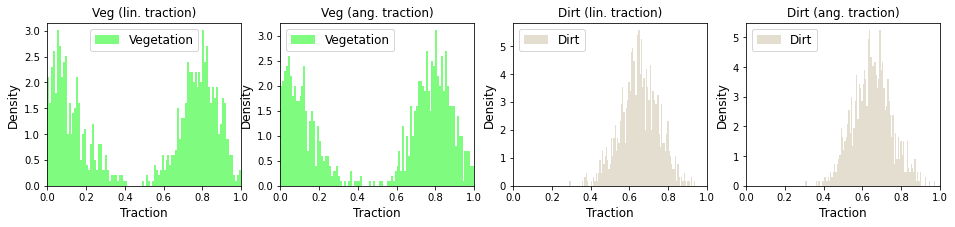

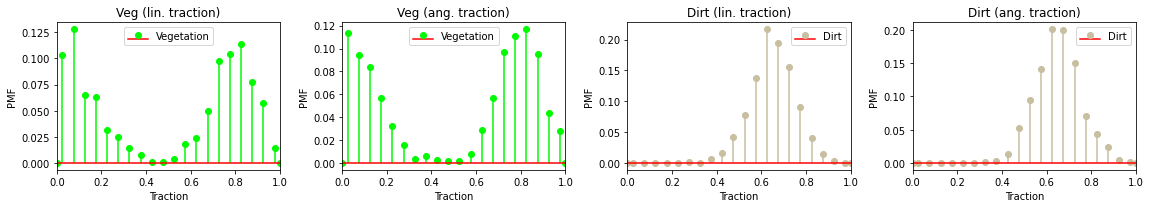

In [22]:
# What percentile of the speed distribution to compute conditional expectation?
pmf_bounds = [0, 1.0]

bush_weights = [0.6, 0.4]
bush_means= [0, 0.8]
bush_std = [0.15, 0.1]

# bush_weights = [0.6, 0.4]
# bush_means= [0, 0.7]
# bush_std = [0.2, 0.2]

dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]

# dirt_weights = [1]
# dirt_means = [1]
# dirt_std = [0.001]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

# Cvar in terrain doesn't matter in this context
bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
print(np.sum(b_lin_pmf))
print(np.sum(b_ang_pmf))
print(np.sum(d_lin_pmf))
print(np.sum(d_ang_pmf))



LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

TDM has initialized GPU memory after 0.04107213020324707 s
TDM has initialized GPU memory after 0.04100465774536133 s
MPPI planner has initialized GPU memory after 0.01752758026123047 s


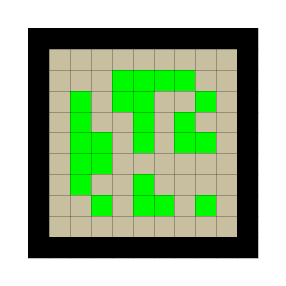

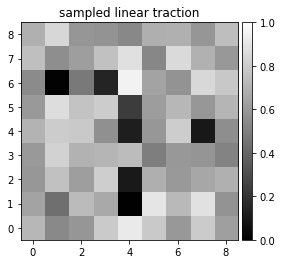

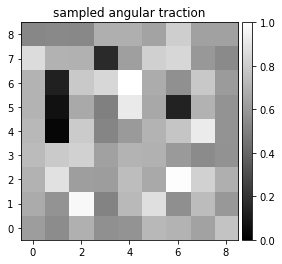

In [19]:
# ------------- Create and visualize the map ------------
# Fixed a sampled environment
grid_shape = (9, 9)
mud_margin = 1

# grid_shape = (11, 11)
# mud_margin = 2

# ----------------------
res = 1.0
# res = 0.1
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
perc_grass = 0.4
# perc_grass = 1.0
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1
# # ----------------------
# # Diagonal band of grass in the middle
# res = 1.0
# # res = 0.1
# semantic_grid = np.zeros(grid_shape, dtype=np.int8)
# valid_mask = np.array([
#   [0,0,0,1,1,1,1,1,1],
#   [0,0,1,1,1,1,1,1,1],
#   [0,1,1,1,1,1,1,1,1],
#   [1,1,1,1,1,1,1,1,1],
#   [1,1,1,1,1,1,1,1,1],
#   [1,1,1,1,1,1,1,1,1],
#   [1,1,1,1,1,1,1,1,0],
#   [1,1,1,1,1,1,1,0,0],
#   [1,1,1,1,1,1,0,0,0],
#   ], dtype=bool)
# rand_num = np.random.rand(np.sum(valid_mask))
# perc_grass = 0.7
# print(rand_num)
# semantic_grid[valid_mask] = rand_num < perc_grass
# # ----------------------

# # Fixed a sampled environment
# grid_shape = (9, 9)
# mud_margin = 1
# res = 1.0
# semantic_grid = np.zeros(grid_shape, dtype=np.int8)
# rand_num = np.random.rand(grid_shape[0], grid_shape[1])
# perc_grass = 0.3
# semantic_grid[rand_num<perc_grass] = 1
# semantic_grid[:mud_margin, :mud_margin] = 0
# semantic_grid[-mud_margin:, -mud_margin:] = 0


xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))
max_speed = 3.0

use_tdm = True # True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 100,
  max_map_dim =(15, 15),
  # max_map_dim =(120, 120),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

# ------------- Problem configuration ------------
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
# x0=np.array([0.2, 0.2, np.pi/4])
# xgoal= np.array([grid_shape[0]-mud_margin/2-5, grid_shape[0]-mud_margin/2])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=0.2, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=0,

    # Hyper parameters
    lambda_weight=0.3,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------
lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                                  det_dynamics_cvar_alpha=mppi_params['alpha_dyn'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                                  det_dynamics_cvar_alpha=mppi_params['alpha_dyn'])


lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))


mppi_planner = MPPI_Numba(cfg)



# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)
plt.show()



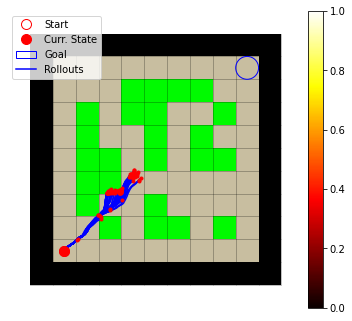

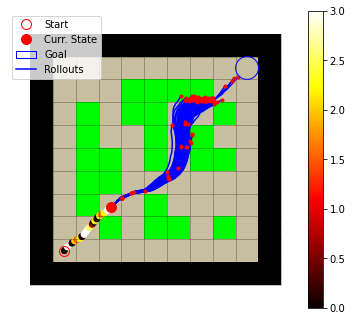

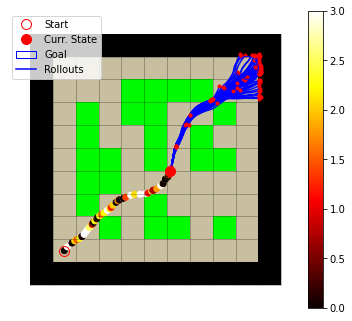

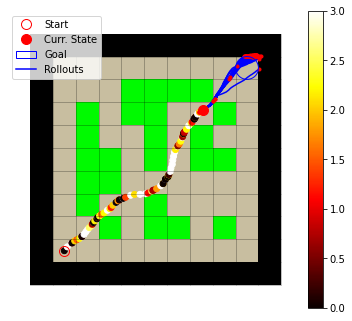

goal reached at t=115


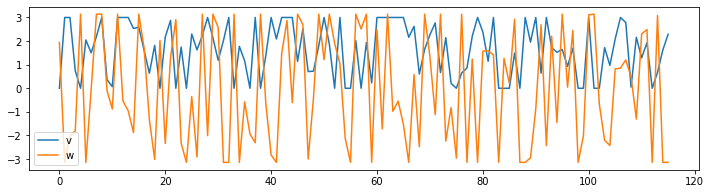

In [20]:

# mppi_params['alpha_dyn']=0.2
# mppi_params['lambda_weight']=1.0


# Construct the MPPI planner + initialize the GPU variables
lin_tdm.reset()
ang_tdm.reset()
mppi_planner.reset()
obstacle_map = None # np.zeros(semantic_grid.shape, dtype=np.int8)
unknown_map = None # np.zeros(semantic_grid.shape, dtype=np.int8)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    det_dynamics_cvar_alpha=mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    det_dynamics_cvar_alpha=mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

# If want to assess the run time
# mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
# %timeit mppi_planner.solve()


# Loop
# max_steps = 151
max_steps = 151
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 30
# plot_every_n = 1
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
    ax.add_patch(c1)

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    
    # ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # sc = ax.scatter(xhist[1:t+1,0], xhist[1:t+1,1], c=np.linalg.norm(uhist[:t], axis=1), cmap='hot')
    sc = ax.scatter(xhist[1:t+1,0], xhist[1:t+1,1], c=np.abs(uhist[:t, 0]), cmap='hot')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax)
    
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    ax.legend()
    plt.tight_layout()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break



fig, ax = plt.subplots(figsize=(12,3))
ax.plot(uhist[:,0], label='v')
ax.plot(uhist[:,1], label='w')
ax.legend()
plt.show()

### Test CVaR related approximations using PMF representation

In [31]:
import numpy as np
pmf = np.random.rand(4, 3, 5)
pmf /= pmf.sum(axis=0)

In [32]:
pmf

array([[[0.16902042, 0.30773715, 0.10985797, 0.32437459, 0.05824078],
        [0.15373448, 0.32728149, 0.24388047, 0.1499522 , 0.28162274],
        [0.14504223, 0.26788741, 0.23519397, 0.31108014, 0.27367253]],

       [[0.4984942 , 0.07365052, 0.4033883 , 0.21707984, 0.23294681],
        [0.44622543, 0.16204386, 0.30288788, 0.40473285, 0.06527213],
        [0.30507393, 0.134482  , 0.30249664, 0.25709251, 0.04141258]],

       [[0.2985472 , 0.4043226 , 0.43766983, 0.17093039, 0.23731749],
        [0.16360141, 0.25814315, 0.26925114, 0.07307253, 0.4639903 ],
        [0.30196077, 0.33992557, 0.2550714 , 0.2576981 , 0.37306071]],

       [[0.03393819, 0.21428973, 0.04908391, 0.28761518, 0.47149492],
        [0.23643867, 0.25253149, 0.18398051, 0.37224241, 0.18911483],
        [0.24792308, 0.25770502, 0.20723799, 0.17412925, 0.31185419]]])

In [33]:
pmf.cumsum(axis=0)>=0.5

array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[ True, False,  True,  True, False],
        [ True, False,  True,  True, False],
        [False, False,  True,  True, False]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])

In [34]:
which_layer = np.argmax(pmf.cumsum(axis=0)>=0.5, axis=0)
print(which_layer)
l, num_rows, num_cols = pmf.shape
output = np.zeros_like(pmf)
output[which_layer.ravel(), np.repeat(np.arange(num_rows), num_cols), np.tile(np.arange(num_cols), num_rows)] = 100
print(output)
assert (np.sum(output, axis=0)==(np.ones((num_rows, num_cols))*100)).all()

[[1 2 1 1 2]
 [1 2 1 1 2]
 [2 2 1 1 2]]
[[[  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]

 [[100.   0. 100. 100.   0.]
  [100.   0. 100. 100.   0.]
  [  0.   0. 100. 100.   0.]]

 [[  0. 100.   0.   0. 100.]
  [  0. 100.   0.   0. 100.]
  [100. 100.   0.   0. 100.]]

 [[  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]


In [35]:
1.1//0.5

2.0

In [36]:
-0.1//0.05

-2.0

Check whether two ranges overlap

In [37]:
def check_overlap(r1, r2):
  bounds = None
  start_in_r1 = None
  overlapping = r1[0]<=r2[1] and r2[0]<=r1[1]
  if overlapping:
    amount_overlap = min(r1[1], r2[1]) - max(r1[0], r2[0])
    if amount_overlap>=0:
      start_in_r1 = np.argmax([r1[0], r2[0]])==0
      start = r1[0] if start_in_r1 else r2[0]
      bounds = [start, start+amount_overlap]
      
  return overlapping, bounds, start_in_r1

def ranges_overlap(r1, r2):
  return r1[0]<=r2[1] and r2[0]<=r1[1]

def maps_overlap(xlim1, ylim1, xlim2, ylim2):
  return ranges_overlap(xlim1, xlim2) and ranges_overlap(ylim1, ylim2)

r1 = [-7.0, -4.9999]
r2 = [-5,1.1]
overlapping, bounds, start_in_r1 = check_overlap(r1, r2)
if overlapping:
  print("Overlap is {}, starting in {}".format(bounds, 'r1' if start_in_r1 else 'r2'))
else:
  print("No overlap")

xlim1 = [0,10]
ylim1 = [0,10]
xlim2 = [5,10]
ylim2 = [-5,11]
print(maps_overlap(xlim1, ylim1, xlim2, ylim2))


Overlap is [-5, -4.9999], starting in r2
True


In [38]:
np.argmax([1,2])

1

### Test CVaR related approximations using risk_traction_map
Represent CVaR traction values between traction_min and traction_max using integer values between 0 and 100 

In [39]:
import numpy as np

pmf = np.random.rand(4, 3, 5)
pmf[0,:,:] = 0
pmf /= pmf.sum(axis=0)
print(pmf)

[[[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.00791057 0.18829556 0.42732974 0.1575004  0.08738073]
  [0.02181804 0.39336523 0.24300295 0.33488059 0.18781493]
  [0.41277098 0.40681003 0.12068443 0.16755007 0.39049381]]

 [[0.54496658 0.4603123  0.12830179 0.53172857 0.07344378]
  [0.94369952 0.16410203 0.165547   0.43757542 0.79249344]
  [0.45759635 0.31276815 0.72087362 0.63373845 0.36297897]]

 [[0.44712285 0.35139214 0.44436847 0.31077103 0.83917549]
  [0.03448244 0.44253274 0.59145005 0.22754399 0.01969163]
  [0.12963267 0.28042182 0.15844195 0.19871148 0.24652722]]]


In [40]:
bin_values_bounds = np.asarray([0.0, 1.0])
bin_values = np.asarray([0.0, 0.3, 0.7,1.0])
traction_range = bin_values_bounds[1]-bin_values_bounds[0]
cvar_alpha=0.0001

weighted_values = pmf*bin_values.reshape((-1,1,1))
weighted_values_cumsum = np.cumsum(weighted_values, axis=0)
pmf_cumsum = pmf.cumsum(axis=0)
if cvar_alpha==1.0:
  which_layer = np.ones(pmf.shape[1:], dtype=int)*(pmf.shape[0]-1)
else:
  which_layer = np.argmax(pmf_cumsum>=cvar_alpha, axis=0)
print(pmf_cumsum)
print(which_layer)
# print(weighted_values_cumsum)

_, num_rows, num_cols = pmf.shape
l_indices = which_layer.ravel()
r_indices = np.repeat(np.arange(num_rows), num_cols)
c_indices = np.tile(np.arange(num_cols), num_rows)
v = weighted_values_cumsum[l_indices, r_indices, c_indices] / pmf_cumsum[l_indices, r_indices, c_indices].ravel()
print(v.reshape(num_rows, num_cols))



[[[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.00791057 0.18829556 0.42732974 0.1575004  0.08738073]
  [0.02181804 0.39336523 0.24300295 0.33488059 0.18781493]
  [0.41277098 0.40681003 0.12068443 0.16755007 0.39049381]]

 [[0.55287715 0.64860786 0.55563153 0.68922897 0.16082451]
  [0.96551756 0.55746726 0.40854995 0.77245601 0.98030837]
  [0.87036733 0.71957818 0.84155805 0.80128852 0.75347278]]

 [[1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
[[0.3 0.3 0.3 0.3 0.3]
 [0.3 0.3 0.3 0.3 0.3]
 [0.3 0.3 0.3 0.3 0.3]]


In [41]:
a = np.random.randint(0,10, (10,10))
print(a)

[[3 3 5 9 9 5 6 8 0 2]
 [0 9 2 9 9 9 6 9 2 2]
 [6 6 8 7 0 8 7 2 3 1]
 [0 4 2 5 0 5 4 5 2 9]
 [8 9 3 2 6 7 9 2 1 0]
 [0 7 4 9 6 9 8 6 3 1]
 [6 4 7 8 0 4 5 0 2 4]
 [4 0 8 3 9 5 9 2 0 0]
 [9 8 9 2 0 4 6 5 9 3]
 [2 2 7 0 4 4 9 7 1 3]]


In [42]:
temp = np.zeros((2, 10,10))
# temp[:,a==7] = np.array([1,2]).reshape(2,1)
temp[:,a==7] = np.reshape([2,3], (2,1))
print(temp)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 2. 0. 0. 2. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
  [0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 2. 0. 0. 0. 0. 2. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 3. 0. 0. 3. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 3. 0. 0. 0. 0.]
  [0. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 3. 0. 0. 0. 0. 3. 0. 0.]]]


In [43]:
np.argwhere(np.random.rand(3,3)>0.5)

array([[0, 0],
       [0, 2],
       [1, 0],
       [2, 2]])

In [44]:
means = np.random.rand(3,3)
means = np.ones((3,3))
bin_values = np.array([0.0,0.1,0.4,0.8,1.0])

In [45]:
print(means)
np.argmax(means <= bin_values.reshape((-1, 1, 1)), axis=0)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


array([[4, 4, 4],
       [4, 4, 4],
       [4, 4, 4]])

In [46]:
np.ones((3,3),dtype=int).astype(float)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])